In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lib.exponential_fitting import fit_exponential_n, show_elbow_n

In [2]:
T_max = 60.0

Henri = {
    'FLOPS_p_W':65.396*1.e+9,
    'R_max':2.88*1.e+15,
    'Power':44*1.e3
}

LUMI = {
    'FLOPS_p_W':53.428*1.e+9,
    'R_max':379.70*1.e+15,
    'Power':7107*1.e3 	
}

qubit_power = 30*1e-3        

In [3]:
def T_layers(n, r, ent = 'full', t_one = 50*1.e-9, t_two = 50*1.e-9):
    return( r*(t_one*(2+n*(n-1)/2)+t_two*(n*(n-1))) )

def T_circ(n, r, ent = 'full', t_one = 50*1.e-9, t_two = 50*1.e-9, t_meas = 100*1.e-9):
    return(T_layers(n,r, ent=ent, t_one=t_one, t_two=t_two)+ t_meas)

def T_total(N, n, r, ent = 'full', t_one = 50*1.e-9, t_two = 50*1.e-9, t_meas = 100*1.e-9):
    return(N*T_circ(n=n, r=r, ent = 'full', t_one = 50*1.e-9, t_two = 50*1.e-9, t_meas = 100*1.e-9))

# New

In [4]:
Azure = pd.read_csv('sonar_Azure_6.csv')
CR = pd.read_csv('results/classical_runtime/classical_FLOPS.csv')
N_CA = pd.read_csv('results/N_estimates/N_CA_PQ_sonar_ZZ6.csv')
N_spread = pd.read_csv('results/N_estimates/N_spread_PQ_sonar_ZZ6.csv')
N_spread_noisy = pd.read_csv('results/N_estimates/N_spread_PQ_sonar_ZZ6_noisy.csv')

In [5]:
N_spread = N_spread[N_spread['n']<=N_CA['n'].max()]
N_spread_noisy = N_spread_noisy[N_spread_noisy['n']<=N_CA['n'].max()]

In [6]:
Azure = Azure[['n', 'error_budget', 'physical_qubits', 'runtime']]
QRE = Azure

In [7]:
QRE['N_spread'] = N_spread['N_spread']
QRE['N_spread_noisy'] = N_spread_noisy['N_spread_noisy']
QRE['N_CA'] = N_CA['N_CA']

QRE['N'] = QRE[['N_spread','N_CA']].max(axis=1)
QRE['N_noisy'] = QRE[['N_spread_noisy','N_CA']].max(axis=1)

In [8]:
QRE = QRE.rename(columns={'error_budget':'error', 'runtime':'runtime_per_shot[ns]'})

In [9]:
QRE['runtime_tomography[ns]'] = 3*QRE['runtime_per_shot[ns]']
QRE['total_runtime_noisy[s]'] = QRE['N_noisy']*QRE['runtime_tomography[ns]']*1.e-9
QRE['total_runtime[s]'] = T_total(QRE['N'],QRE['n'], r=6)
QRE['power[W]'] = qubit_power*QRE['physical_qubits']
QRE['energy[J]'] = qubit_power*QRE['n']*QRE['total_runtime[s]']
QRE['energy_noisy[J]'] = QRE['power[W]']*QRE['total_runtime_noisy[s]']

In [11]:
QRE['classical_FLOP'] = CR['FLOPS']
QRE['LUMI_E_MAX'] = LUMI['Power']*QRE['classical_FLOP']/LUMI['R_max']
QRE['LUMI_runtime'] = QRE['classical_FLOP']/LUMI['R_max']
QRE['Henri_E_MAX'] = Henri['Power']*QRE['classical_FLOP']/Henri['R_max']
QRE['Henri_runtime'] = QRE['classical_FLOP']/Henri['R_max']

In [12]:
QRE

,n,error,physical_qubits,runtime_per_shot[ns],N_spread,N_spread_noisy,N_CA,N,N_noisy,runtime_tomography[ns],total_runtime_noisy[s],total_runtime[s],power[W],energy[J],energy_noisy[J],classical_FLOP,LUMI_E_MAX,LUMI_runtime,Henri_E_MAX,Henri_runtime
0,2.0,0.293207,34450.0,234000.0,3.762492e+02,2.393887e+03,1.899616e+01,3.762492e+02,2.393887e+03,702000.0,1.680508e+00,6.019987e-04,1033.50,3.611992e-05,1.736805e+03,1.374700e+04,2.573082e-07,3.620490e-14,2.100236e-07,4.773264e-12
1,3.0,0.195591,25176.0,652400.0,1.547201e+03,8.032161e+03,3.558791e+01,1.547201e+03,8.032161e+03,1957200.0,1.572055e+01,5.260484e-03,755.28,4.734436e-04,1.187341e+04,7.776900e+04,1.455634e-06,2.048170e-13,1.188137e-06,2.700313e-11
2,4.0,0.184199,87710.0,952000.0,7.241331e+03,3.418584e+04,6.667134e+01,7.241331e+03,3.418584e+04,2856000.0,9.763475e+01,4.417212e-02,2631.30,5.300654e-03,2.569063e+05,4.200000e+05,7.861312e-06,1.106136e-12,6.416667e-06,1.458333e-10
3,5.0,0.187274,99764.0,1209600.0,2.801863e+04,1.272788e+05,1.249039e+02,2.801863e+04,1.272788e+05,3628800.0,4.618694e+02,2.717807e-01,2992.92,4.076711e-02,1.382338e+06,2.207408e+06,4.131696e-05,5.813558e-12,3.372429e-05,7.664611e-10
4,6.0,0.147248,115640.0,1587600.0,8.472453e+04,3.552197e+05,2.339982e+02,8.472453e+04,3.552197e+05,4762800.0,1.691841e+03,1.203088e+00,3469.20,2.165559e-01,5.869333e+06,1.118194e+07,2.092969e-04,2.944940e-11,1.708352e-04,3.882618e-09
5,7.0,0.139029,105646.0,2430000.0,2.097366e+05,8.594929e+05,4.383786e+02,2.097366e+05,8.594929e+05,7290000.0,6.265704e+03,4.110838e+00,3169.38,8.632759e-01,1.985840e+07,5.467655e+07,1.023403e-03,1.439993e-10,8.353362e-04,1.898491e-08
6,8.0,0.123056,237330.0,2836800.0,4.482635e+05,1.816163e+06,8.212701e+02,4.482635e+05,1.816163e+06,8510400.0,1.545628e+04,1.161003e+01,7119.90,2.786406e+00,1.100471e+08,2.597020e+08,4.860948e-03,6.839662e-10,3.967669e-03,9.017429e-08
7,9.0,0.121215,257256.0,3261600.0,8.213944e+05,3.306480e+06,1.538589e+03,8.213944e+05,3.306480e+06,9784800.0,3.235324e+04,2.718815e+01,7717.68,7.340802e+00,2.496920e+08,1.205529e+09,2.256438e-02,3.174951e-09,1.841780e-02,4.185864e-07
8,10.0,0.120421,283500.0,3927600.0,1.545647e+06,6.205576e+06,2.882435e+03,1.545647e+06,6.205576e+06,11782800.0,7.311906e+04,6.368065e+01,8505.00,1.910419e+01,6.218776e+08,5.495397e+09,1.028596e-01,1.447300e-08,8.395745e-02,1.908124e-06
9,15.0,0.108276,369684.0,6519600.0,1.785599e+07,6.653584e+07,6.651860e+04,1.785599e+07,6.653584e+07,19558800.0,1.301361e+06,1.699891e+03,11090.52,7.649508e+02,1.443277e+10,1.296679e+13,2.427046e+02,3.415008e-05,1.981037e+02,4.502356e-03


## Plots

### Runtime

In [14]:
n_limit = 10 #Simulations were performed up to 10 qubits

In [27]:
df_advantage_T = QRE[QRE['LUMI_runtime'] >= QRE['total_runtime_noisy[s]']][['n', 'total_runtime_noisy[s]', 'LUMI_runtime']]
advantage_index = df_advantage_T.index[0]
df_interpolation = QRE.iloc[[advantage_index-1, advantage_index],:][['n', 'total_runtime_noisy[s]', 'LUMI_runtime']]

n_1, T_1= df_interpolation[['n','total_runtime_noisy[s]']].iloc[0,[0,1]]
n_2, T_2 = df_interpolation[['n','total_runtime_noisy[s]']].iloc[1,[0,1]]
T_1 = np.log(T_1)
T_2 = np.log(T_2)

cT_1 = df_interpolation[['n','LUMI_runtime']].iloc[0,1]
cT_2 = df_interpolation[['n','LUMI_runtime']].iloc[1,1]
cT_1 = np.log(cT_1)
cT_2 = np.log(cT_2)

a_Q = (T_1-T_2)/(n_1-n_2)
b_Q = T_1 - a_Q*n_1

a_C = (cT_1-cT_2)/(n_1-n_2)
b_C = cT_1 - a_C*n_1

x = (b_C-b_Q)/(a_Q-a_C)
y = np.exp(a_Q*x+b_Q)

print(x,y)

37.125418710010116 26043628490.96404


In [16]:
df_advantage_T.loc[-1] = [x,y,y]
df_advantage_T.index = df_advantage_T.index + 1
df_advantage_T = df_advantage_T.sort_index()

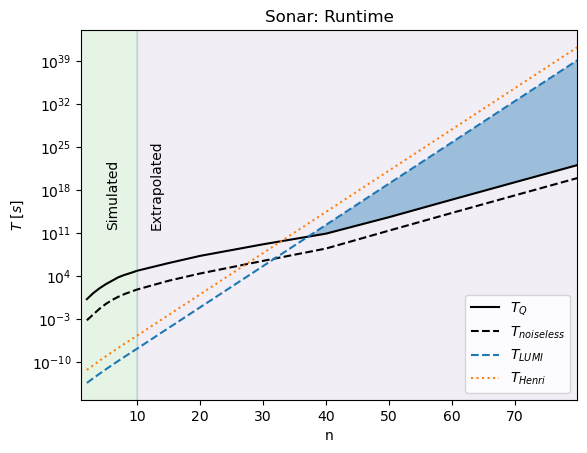

In [17]:
bg_color = [plt.cm.Accent(i) for i in range(2)]
#n_limit = N_simulated['n'].to_numpy()[-1]

plt.plot(QRE['n'], QRE['total_runtime_noisy[s]'], color='black', label='$T_Q$')
plt.plot(QRE['n'], QRE['total_runtime[s]'], color='black', linestyle='--', label='$T_{noiseless}$')
plt.plot(QRE['n'], QRE['LUMI_runtime'], color='#1f77b4', linestyle='--', label='$T_{LUMI}$')
plt.plot(QRE['n'], QRE['Henri_runtime'], color='#ff7f0e', linestyle='dotted', label='$T_{Henri}$')

#plt.plot(RE['n'], RE['FT_runtime[s]'], color='black', label='$T_Q$')
#plt.plot(RE['n'], RE['noiseless_runtime[s]'], color='black', linestyle='--', label='$T_{noiseless}$')
#plt.plot(RE['n'], RE['LUMI_runtime'], color='#1f77b4', linestyle='--', label='$T_{LUMI}$')
#plt.plot(RE['n'], RE['Henri_runtime'], color='#ff7f0e', linestyle='dotted', label='$T_{Henri}$')


left,right = plt.xlim()

#plt.axvline(37)
#plt.axhline(1.0e10)

plt.axvline(n_limit, alpha=0.1)
plt.axvspan(-10, n_limit, alpha=0.2, color=bg_color[0])

plt.axvspan(n_limit, QRE['n'].max()+10, alpha=0.2, color=bg_color[1])
#plt.axvspan(n_limit, N_ext['n'].to_numpy()[-1]+10, alpha=0.2, color=bg_color[1])

plt.text(n_limit-5,1.e12,'Simulated', rotation='vertical')
plt.text(n_limit+2,1.e12,'Extrapolated', rotation='vertical')

plt.fill_between(df_advantage_T['n'], df_advantage_T['total_runtime_noisy[s]'], df_advantage_T['LUMI_runtime'], alpha = .4)
plt.yscale('log')
plt.legend()
plt.xlabel('n')
plt.ylabel(r'$T\ [s]$')
plt.xlim((left+3,right-4))
plt.title('Sonar: Runtime')
#plt.savefig('imgs/T_advantage.pdf', transparent = True)
plt.show()

### Energy consumption

In [26]:
df_advantage_E = QRE[QRE['Henri_E_MAX'] >= QRE['energy[J]']][['n', 'energy_noisy[J]', 'Henri_E_MAX']]
advantage_index = df_advantage_E.index[0]
df_interpolation = QRE.iloc[[advantage_index-1, advantage_index],:][['n', 'energy_noisy[J]', 'Henri_E_MAX']]

n_1, T_1= df_interpolation[['n','energy_noisy[J]']].iloc[0,[0,1]]
n_2, T_2 = df_interpolation[['n','energy_noisy[J]']].iloc[1,[0,1]]
T_1 = np.log(T_1)
T_2 = np.log(T_2)

cT_1 = df_interpolation[['n','Henri_E_MAX']].iloc[0,1]
cT_2 = df_interpolation[['n','Henri_E_MAX']].iloc[1,1]
cT_1 = np.log(cT_1)
cT_2 = np.log(cT_2)

a_Q = (T_1-T_2)/(n_1-n_2)
b_Q = T_1 - a_Q*n_1

a_C = (cT_1-cT_2)/(n_1-n_2)
b_C = cT_1 - a_C*n_1

x = (b_C-b_Q)/(a_Q-a_C)
y = np.exp(a_Q*x+b_Q)

print(x,y)

33.06511475674425 280610311518567.25


In [19]:
df_advantage_E.loc[-1] = [x,y,y]
df_advantage_E.index = df_advantage_E.index + 1
df_advantage_E = df_advantage_E.sort_index()

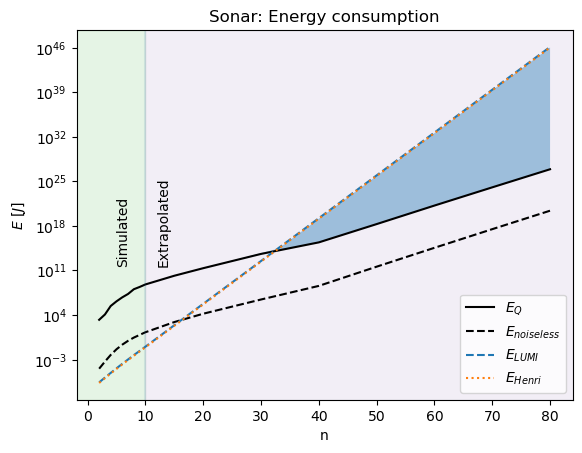

In [20]:
bg_color = [plt.cm.Accent(i) for i in range(2)]


plt.plot(QRE['n'], QRE['energy_noisy[J]'], color='black', label='$E_Q$')
plt.plot(QRE['n'], QRE['energy[J]'], color='black', linestyle='--', label='$E_{noiseless}$')
plt.plot(QRE['n'], QRE['LUMI_E_MAX'], color='#1f77b4', linestyle='--', label='$E_{LUMI}$')
plt.plot(QRE['n'], QRE['Henri_E_MAX'], color='#ff7f0e', linestyle='dotted', label='$E_{Henri}$')


left,right = plt.xlim()

#plt.axvline(32)
#plt.axhline(1.0e10)

plt.axvline(n_limit, alpha=0.1)
plt.axvspan(-10, n_limit, alpha=0.2, color=bg_color[0])
plt.axvspan(n_limit, QRE['n'].max()+10, alpha=0.2, color=bg_color[1])

plt.text(n_limit-5,1.e12,'Simulated', rotation='vertical')
plt.text(n_limit+2,1.e12,'Extrapolated', rotation='vertical')

plt.fill_between(df_advantage_E['n'], df_advantage_E['energy_noisy[J]'], df_advantage_E['Henri_E_MAX'], alpha = .4)
plt.yscale('log')
plt.legend()
plt.xlabel('n')
plt.ylabel(r'$E\ [J]$')
plt.xlim((left,right))
plt.title('Sonar: Energy consumption')
#plt.savefig('imgs/E_advantage.pdf', transparent = True)
plt.show()

### Together

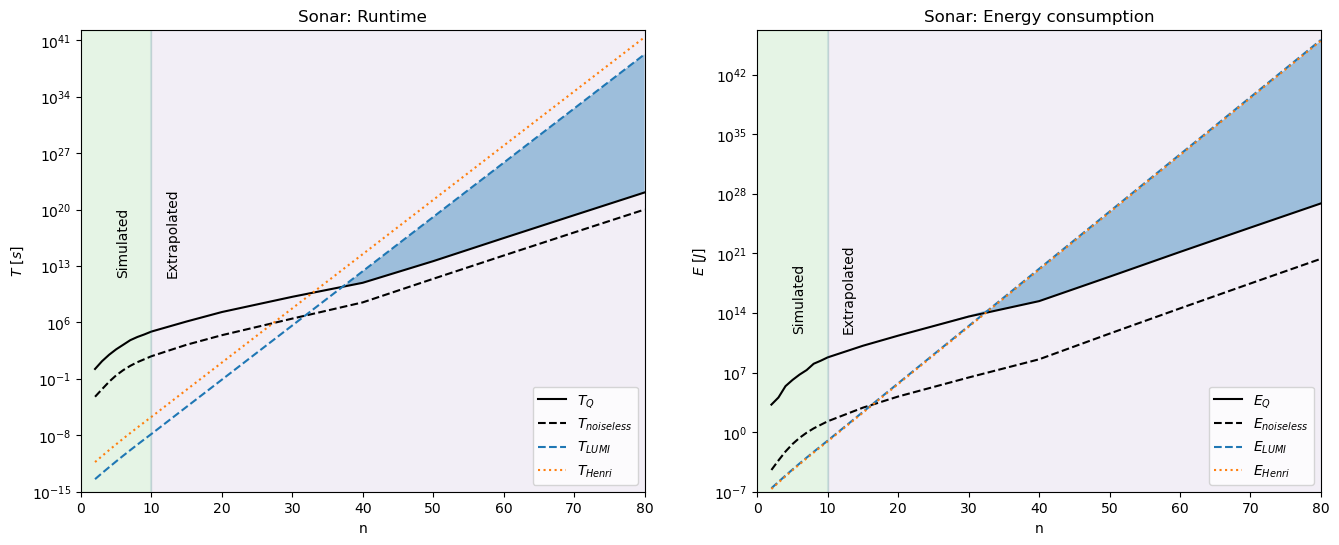

In [25]:
#color = cm.rainbow(np.linspace(0, 1, N_SR_FQ.shape[0]))

#bg_color = [plt.cm.Accent(i) for i in range(2)]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

##############RUNTIME

bg_color = [plt.cm.Accent(i) for i in range(2)]

ax[0].plot(QRE['n'], QRE['total_runtime_noisy[s]'], color='black', label='$T_Q$')
ax[0].plot(QRE['n'], QRE['total_runtime[s]'], color='black', linestyle='--', label='$T_{noiseless}$')
ax[0].plot(QRE['n'], QRE['LUMI_runtime'], color='#1f77b4', linestyle='--', label='$T_{LUMI}$')
ax[0].plot(QRE['n'], QRE['Henri_runtime'], color='#ff7f0e', linestyle='dotted', label='$T_{Henri}$')

#plt.axvline(50)
#plt.axhline(5.0e5)

ax[0].axvline(n_limit, alpha=0.1)
ax[0].axvspan(-10, n_limit, alpha=0.2, color=bg_color[0])
ax[0].axvspan(n_limit, QRE['n'].max()+10, alpha=0.2, color=bg_color[1])

ax[0].text(n_limit-5,1.e12,'Simulated', rotation='vertical')
ax[0].text(n_limit+2,1.e12,'Extrapolated', rotation='vertical')

ax[0].fill_between(df_advantage_T['n'], df_advantage_T['total_runtime_noisy[s]'], df_advantage_T['LUMI_runtime'], alpha = .4)
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_xlabel('n')
ax[0].set_ylabel(r'$T\ [s]$')
ax[0].set_xlim((0,80))
ax[0].set_ylim((1.e-15,2.e42))
ax[0].set_title(r'Sonar: Runtime')

##############
##############ENERGY
ax[1].plot(QRE['n'], QRE['energy_noisy[J]'], color='black', label='$E_Q$')
ax[1].plot(QRE['n'], QRE['energy[J]'], color='black', linestyle='--', label='$E_{noiseless}$')
ax[1].plot(QRE['n'], QRE['LUMI_E_MAX'], color='#1f77b4', linestyle='--', label='$E_{LUMI}$')
ax[1].plot(QRE['n'], QRE['Henri_E_MAX'], color='#ff7f0e', linestyle='dotted', label='$E_{Henri}$')

#plt.axvline(26)
#plt.axhline(2.0e9)

ax[1].axvline(n_limit, alpha=0.1)
ax[1].axvspan(-10, n_limit, alpha=0.2, color=bg_color[0])
ax[1].axvspan(n_limit, QRE['n'].max()+10, alpha=0.2, color=bg_color[1])

ax[1].text(n_limit-5,1.e12,'Simulated', rotation='vertical')
ax[1].text(n_limit+2,1.e12,'Extrapolated', rotation='vertical')

ax[1].fill_between(df_advantage_E['n'], df_advantage_E['energy_noisy[J]'], df_advantage_E['Henri_E_MAX'], alpha = .4)
ax[1].set_yscale('log')
ax[1].legend()
ax[1].set_xlabel('n')
ax[1].set_ylabel(r'$E\ [J]$')
ax[1].set_xlim((0,80))
ax[1].set_ylim((1.e-7,2.e47))
ax[1].set_title(r'Sonar: Energy consumption')
##############

#plt.savefig('imgs/resource_comparison_sonar.pdf', transparent=True, bbox_inches='tight')
plt.show()